In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace,explode,count,col
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Intialising SparkSession object

spark = SparkSession \
.builder \
.config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.1,com.amazonaws:aws-java-sdk:1.12.180") \
.config("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem") \
.getOrCreate()

In [17]:
#Reading json file from s3 bucket
df = spark.read.format('json').option('header','true').option('inferSchema','true').load(f's3a://YOUR_BUCKET_NAME/')
df.show()
df.printSchema()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                etag|                  id|                kind|             replies|             snippet|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|1YNhqPv0eeu1d3j-T...|UgwhXl1hoc6nFe_Hp...|youtube#commentTh...|                null|{true, true, {On-...|
|aIqb0JwUkSIQS6V88...|Ugytil9G5zrD4Dm2g...|youtube#commentTh...|                null|{true, true, {23-...|
|alTAWp8NUc0hlCWuG...|Ugy9EZMMq8Bdyqvtw...|youtube#commentTh...|                null|{true, true, {5m6...|
|P0z1pD_eALsgrWI5E...|UgwI9GxOnIKsuS0jE...|youtube#commentTh...|                null|{true, true, {tKc...|
|0SUacS6F3VDkP93iW...|Ugx1dxHu5Bak0y6qZ...|youtube#commentTh...|                null|{true, true, {XVE...|
|FJ71-tCO2sxMWbk80...|Ugxvg0w7IStDv2aaY...|youtube#commentTh...|                null|{true, true, {kOa...|
|tgT9Iky8v0gH-aO2A...|UgzfVxBlhqBUPZ5

In [18]:
#Selecting comment text 
df = df.select('snippet.topLevelComment.snippet.textDisplay')
df.show()

+--------------------+
|         textDisplay|
+--------------------+
|And then we learn...|
|it is real it hap...|
|            Mükemmel|
|RDJ Was the perfe...|
|The future is goi...|
|Isn't he the same...|
|Artificial Intell...|
|zjedz się !!!\nAm...|
|I WILL LISTEN TO ...|
|             ChatGPT|
|5:50 AGI .. Umm 3...|
|This creative vid...|
|If even Tony Star...|
|Coming back to th...|
|"We don't program...|
|        Now... 2023.|
|And didnt it turn...|
|Ahhh yes youtube!...|
|3 Years later and...|
|who's here after ...|
+--------------------+
only showing top 20 rows



In [19]:
#Removing links from text
df = df.withColumn('textDisplay',regexp_replace('textDisplay',r'http.*?\s+',''))
df = df.withColumn('textDisplay',regexp_replace('textDisplay',r'http.*?$',''))

In [20]:
#Cleaning to retain words from text
df = df.withColumn('textDisplay',regexp_replace('textDisplay',r'[^a-zA-Z\s]+',' '))
df = df.withColumn('textDisplay',regexp_replace('textDisplay',r'\s+',' '))

In [21]:
#Tockenizing and removing stop words
from pyspark.ml.feature import StopWordsRemover, Tokenizer
tokenizer = Tokenizer(inputCol="textDisplay", outputCol="words")
df = tokenizer.transform(df)
# Define the list of stop words
stop_words = stopwords.words('english')+[' ','']
stopword_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stop_words)

# Remove stop words
df = stopword_remover.transform(df)

In [22]:
df = df.select('filtered_words')
df.show()

+--------------------+
|      filtered_words|
+--------------------+
|[learn, robert, d...|
|   [real, happening]|
|            [kemmel]|
|[rdj, perfect, pe...|
|[future, going, a...|
|[guy, created, ul...|
|[artificial, inte...|
|[zjedz, si, amon,...|
|[listen, tony, st...|
|           [chatgpt]|
|[agi, umm, years,...|
|[creative, video,...|
|[even, tony, star...|
|[coming, back, vi...|
|[program, machine...|
|                  []|
|[didnt, turn, mar...|
|[ahhh, yes, youtu...|
|[years, later, mi...|
|[gpt, chat, contr...|
+--------------------+
only showing top 20 rows



In [23]:
df = df.select((explode('filtered_words').alias('words')))

In [24]:
#Generating frequency table and selection top 1000 records
df = df.groupBy('words').agg(count('words').alias('freq'))
df = df.orderBy(col('freq').desc()).limit(1000)
df.show()

+------------+----+
|       words|freq|
+------------+----+
|          ai|  40|
|     youtube|  28|
|      google|  23|
|       natos|   9|
|  algorithms|   9|
|     powered|   8|
|     systems|   8|
|corporations|   7|
|        zero|   7|
|    learning|   7|
|    machines|   7|
|      allies|   7|
|       video|   6|
|        used|   5|
|    customer|   5|
|        real|   5|
|    language|   5|
|        time|   5|
|    channels|   5|
|       human|   4|
+------------+----+
only showing top 20 rows



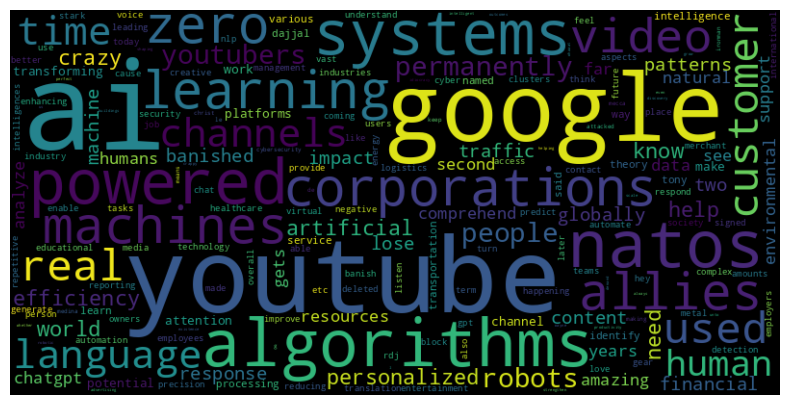

In [25]:
df = df.toPandas()
word_frequency = dict(zip(df['words'], df['freq']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_frequency)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
